## Лабораторная работа №1.Вариант 4. QR-разложение.

In [22]:
import numpy as np
from numba import jit
import time
import matplotlib.pyplot as plt

In [23]:
@jit(nopython=True)
def matmul(A, B):
    n = A.shape[0]
    k = A.shape[1]
    m = B.shape[1]
    C = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            for s in range(k):
                C[i, j] += A[i, s] * B[s, j]
    return C

def qr_decomposition(A):
    m, n = A.shape[0], A.shape[1]
    Q = np.zeros((m, n))
    for i in range(n):
        Q[:, i] = A[:, i]
        for j in range(i):
            Q[:, i] -= Q[:, j] * np.dot(Q[:, i], Q[:, j])
        Q[:, i] /= np.linalg.norm(Q[:, i])
    R = Q.T @ A
    return Q, R

def least_squares(A, b):
    m, n = A.shape[0], A.shape[1]
    Q, R = qr_decomposition(A)
    b_1 = Q.T @ b
    R = np.flip(R, 0)
    R = np.flip(R, 1)
    b_1 = np.flip(b_1, 0)
    x = np.zeros(n)
    for i in range(n):
        sum = 0
        for j in range(i):
            sum += R[i][j] * x[j]
        x[i] = (b_1[i] - sum) / R[i][i]
    return np.flip(x, 0)

In [24]:
for i in range(5):
  A = np.random.rand(100, 100)
  b = np.random.rand(100)
  x_np = np.linalg.solve(A, b)
  x_my = least_squares(A, b)
  print('Norm difference is:', np.linalg.norm(x_np - x_my))

for i in range(5):
  A = np.random.rand(200, 100)
  b = np.random.rand(200)
  np_sol = np.linalg.lstsq(A, b, rcond=None)[0]
  my_sol = least_squares(A, b)
  print('Norm difference is:', np.linalg.norm(np_sol - my_sol))

Norm difference is: 2.1386408689336528e-13
Norm difference is: 9.544354796934516e-12
Norm difference is: 3.865869210075281e-12
Norm difference is: 1.7435503343365934e-11
Norm difference is: 2.0352664354902154e-13
Norm difference is: 9.092934041127864e-15
Norm difference is: 1.0304481879819949e-14
Norm difference is: 1.0834229200753858e-14
Norm difference is: 9.430603724450535e-15
Norm difference is: 5.2851324438575664e-15


In [58]:
A = np.array([[4, -8, 3], [-3, -9, 4], [0, 9, 10]])
b = np.array([-1, -8, 19])
qr_decomposition(A)


(array([[ 0.8 , -0.48,  0.36],
        [-0.6 , -0.64,  0.48],
        [ 0.  ,  0.6 ,  0.8 ]]),
 array([[ 5.00000000e+00, -1.00000000e+00,  4.44089210e-16],
        [ 6.66133815e-16,  1.50000000e+01,  2.00000000e+00],
        [-3.88578059e-16,  2.22044605e-16,  1.10000000e+01]]))

In [59]:
least_squares(A, b)

array([1., 1., 1.])

## Лабораторная работа №2. Вариант 1. Метод Ричардсона.

In [31]:
def richardson(A, b, tau, max_iter = 1000, tol = 1e-6):
    start = time.time()
    n = A.shape[0]
    x_k = np.zeros(n)
    res_richardson = []
    iterations = 0     
    for k in range(max_iter):
        res = A @ x_k - b
        res_richardson.append(np.linalg.norm(res))
        if np.linalg.norm(res) <= tol:
            break
        x_k = x_k - tau * res
        iterations += 1
    
    end = time.time()
    print('Количество итераций:', iterations)
    print('Время работы в секундах:', end - start)
    return x_k, res_richardson

In [54]:
def gershgorin_circle(A):
    eigenvalues = []
    for i in range(A.shape[0]):
        R = sum(np.abs(A[:, i])) - np.abs(A[i][i])
        eigenvalues.append(np.abs(A[i][i]) + R)
        if np.abs(A[i][i]) - R < 0:
            eigenvalues.append(0)
        else:
            eigenvalues.append(np.abs(A[i][i]) - R)
    lambd_min = min(eigenvalues)
    lambd_max = max(eigenvalues)
    return lambd_min, lambd_max
        


def test(size):
  A = np.random.rand(size, size)
  A = (A + A.T) / 2 + np.eye(size) * size
  b = np.random.rand(size)
  eigenvalues = np.linalg.eigvals(A)
  a_min, a_max = gershgorin_circle(A)
  tau_1 = 2 / (min(eigenvalues) + max(eigenvalues))
  tau_2 = 2 / (a_max + a_min)
  my_sol_1, residuals_1 = richardson(A, b, tau_1, 100, 1e-8)
  my_sol_2, residuals_2 = richardson(A, b, tau_2, 100, 1e-8)
  start = time.time()
  np_sol = np.linalg.solve(A, b)
  end = time.time()
  print('Время вычисления точного решения в секундах:', end - start)
  print('Норма ошибки:', np.linalg.norm(my_sol_1 - np_sol))
  plt.figure(figsize=(8, 5))
  plt.plot(range(len(residuals_1)), np.log(residuals_1), range(len(residuals_2)), np.log(residuals_2))
  plt.xlabel('Номер итерации')
  plt.ylabel('Логарифм невязки')
  plt.title('График зависимости')
  plt.show()

Количество итераций: 15
Время работы в секундах: 0.41045451164245605
Количество итераций: 33
Время работы в секундах: 0.8760161399841309
Время вычисления точного решения в секундах: 3.8123767375946045
Норма ошибки: 1.5434046846419127e-13


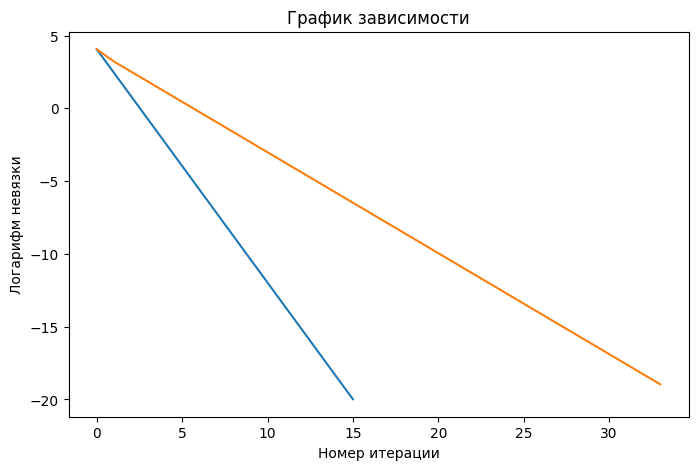

In [55]:
test(10000)

In [50]:
def test_gersh(size):
  A = np.random.rand(size, size)
  A = (A + A.T) / 2 + np.eye(size) * size
  b = np.random.rand(size)
  a_min, a_max = gershgorin_circle(A)
  tau = 2 / (a_min + a_max)
  my_sol, residuals = richardson(A, b, tau, 100, 1e-8)
  start = time.time()
  np_sol = np.linalg.solve(A, b)
  end = time.time()
  print('Время вычисления точного решения в секундах:', end - start)
  print('Норма ошибки:', np.linalg.norm(my_sol - np_sol))
  x_axis = range(len(residuals))
  plt.figure(figsize=(8, 5))
  plt.plot(x_axis, np.log(residuals))
  plt.xlabel('Номер итерации')
  plt.ylabel('Логарифм невязки')
  plt.title('График зависимости')
  plt.show()

Количество итераций: 33
Время работы в секундах: 1.3469319343566895
Время вычисления точного решения в секундах: 4.3292076587677
Норма ошибки: 3.872107380764319e-13


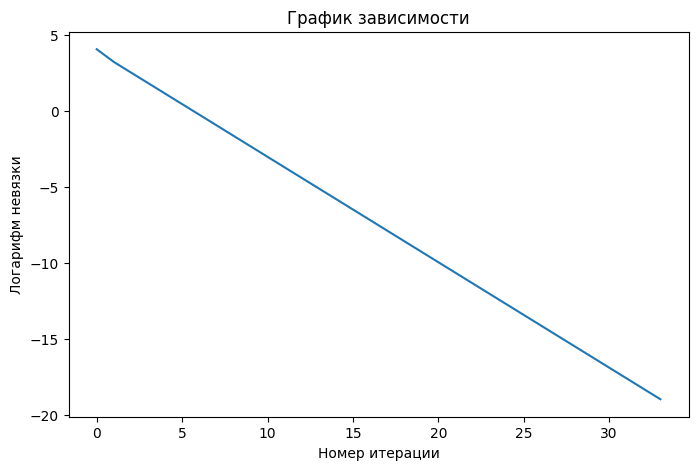

In [51]:
test_gersh(10000)